In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For regular expressions
import re

# For preprocessing and sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from textblob import TextBlob
import spacy
import spacy.cli

spacy.cli.download("en_core_web_sm")
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Load the data
data = pd.read_csv("data/ryanair_reviews.csv")
comments = data[["Comment title", "Comment"]]
comments.head()

,Comment title,Comment
0,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...
1,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...
2,“Really impressed!”,"Really impressed! You get what you pay for, th..."
3,“a decent offering from Ryanair”,I should like to review my flight from Faro to...
4,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w..."


**Preprocessing: (Optional)**
No preprocessing is necessary as it is done by VADER.

Source: [An Introduction to VADER](https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53)

For comparison we preprocessed the data based on the approach by Aljedaani et al. (2022) in their paper "Sentiment analysis on Twitter data integrating TextBlob and deep
learning models: The case of US airline industry" (we excluded the spell correction as this is the most computationally expensive step)

Other sources:
- [British Airways Sentiment Analysis Notebook](https://github.com/Horace-code/British-Airways-Sentiment-Analysis/blob/main/British_Airways_Sentiment_Analysis.ipynb)
- [Sentiment Analysis using VADER](https://akladyous.medium.com/sentiment-analysis-using-vader-c56bcffe6f24)


In [3]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

'''
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def remove_punctuation(text):
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra white spaces
    punc = '!()-[]{};:"\,<>./?@#$%^&*_~'
    # Use a list comprehension to create a new string without punctuation
    no_punc = ''.join(char for char in text if char not in punc)
    return no_punc

# Function for removing punctuation
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Function for removing numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Function for lowercasing the text
def to_lower(text):
    return text.lower()

# Function to tokenize the text
def tokenize(text):
    return word_tokenize(text)

# Function to correct the spelling
def spell_correction(tokens):
    return [str(TextBlob(token).correct()) for token in tokens]

# Function to remove stopwords and non-alphabetic tokens
def remove_stopwords_and_non_alphabetic_tokens(tokens):
    # Remove the stopwords and non-alphabetic tokens
    stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords and word.isalpha()]
    
# Function to stem the text
def stem(tokens):
    return [stemmer.stem(token) for token in tokens]

# Function to lemmatize the text
def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Function combine tokens to a string
def to_string(tokens):
    return ' '.join(tokens)

# Problem here is that the function has a runtime of O(n^2) because of the spell_correction function, making it too slow for large datasets such as this one.
# Function to preprocess the text
def preprocess(text):
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = to_lower(text)
    tokens = tokenize(text)
    tokens = spell_correction(tokens)
    tokens = remove_stopwords_and_non_alphabetic_tokens(tokens)
    tokens = lemmatize(tokens)
    text = to_string(tokens)
    return text
'''


# Function to preprocess text using spaCy
def spacy_process(text):
    # Remove punctuation: This regular expression finds all characters that are not word characters (\w) 
    # or whitespace (\s) and replaces them with an empty string, effectively removing punctuation.
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers: This regular expression finds all digit characters (\d) and replaces them with an empty string,
    # effectively removing all numeric characters from the text
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase: This ensures that all characters in the text are lowercase, making the text case-insensitive.
    text = text.lower()

    # Tokenize the text: The spaCy model processes the text and returns a Doc object, which contains a sequence of tokens.
    doc = nlp(text)

    # Lemmatize and remove stopwords:
    # - token.lemma_: The lemma (base form) of the token.
    # - token.is_alpha: Checks if the token consists of alphabetic characters only.
    # - not token.is_stop: Checks if the token is not a stopword.
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Join tokens into a single string with spaces between them: This creates a single string from the list of tokens
    return ' '.join(tokens)


# Helper function to apply func to a pandas Series
comments["cleaned_Comment"] = comments["Comment"].apply(spacy_process)


In [4]:
sia = SentimentIntensityAnalyzer()
sia_cleaned = SentimentIntensityAnalyzer()

In [5]:
# Add sentiment scores to the data frame
comments["score"] = comments["Comment"].apply(lambda x: sia.polarity_scores(x))
comments['negative'] = comments['score'].apply(lambda x: x['neg'])
comments['neutral'] = comments['score'].apply(lambda x: x['neu'])
comments['positive'] = comments['score'].apply(lambda x: x['pos'])
comments['compound'] = comments['score'].apply(lambda x: x['compound'])

comments["score_cleaned"] = comments["cleaned_Comment"].apply(lambda x: sia_cleaned.polarity_scores(x))
comments['negative_cleaned'] = comments['score_cleaned'].apply(lambda x: x['neg'])
comments['neutral_cleaned'] = comments['score_cleaned'].apply(lambda x: x['neu'])
comments['positive_cleaned'] = comments['score_cleaned'].apply(lambda x: x['pos'])
comments['compound_cleaned'] = comments['score_cleaned'].apply(lambda x: x['compound'])

comments.drop(columns=["score"], inplace=True)
comments.drop(columns=["score_cleaned"], inplace=True)

In [6]:
# Define the function for the emotion (positive, negative, neutral)
def final_sentiment(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.05:
        return "negative"
    elif compound >= -0.05 and compound <= 0.05:
        return "neutral"

In [7]:
comments["sentiment"] = comments["compound"].apply(lambda compound : final_sentiment(compound))

comments["sentiment_cleaned"] = comments["compound_cleaned"].apply(lambda compound : final_sentiment(compound))

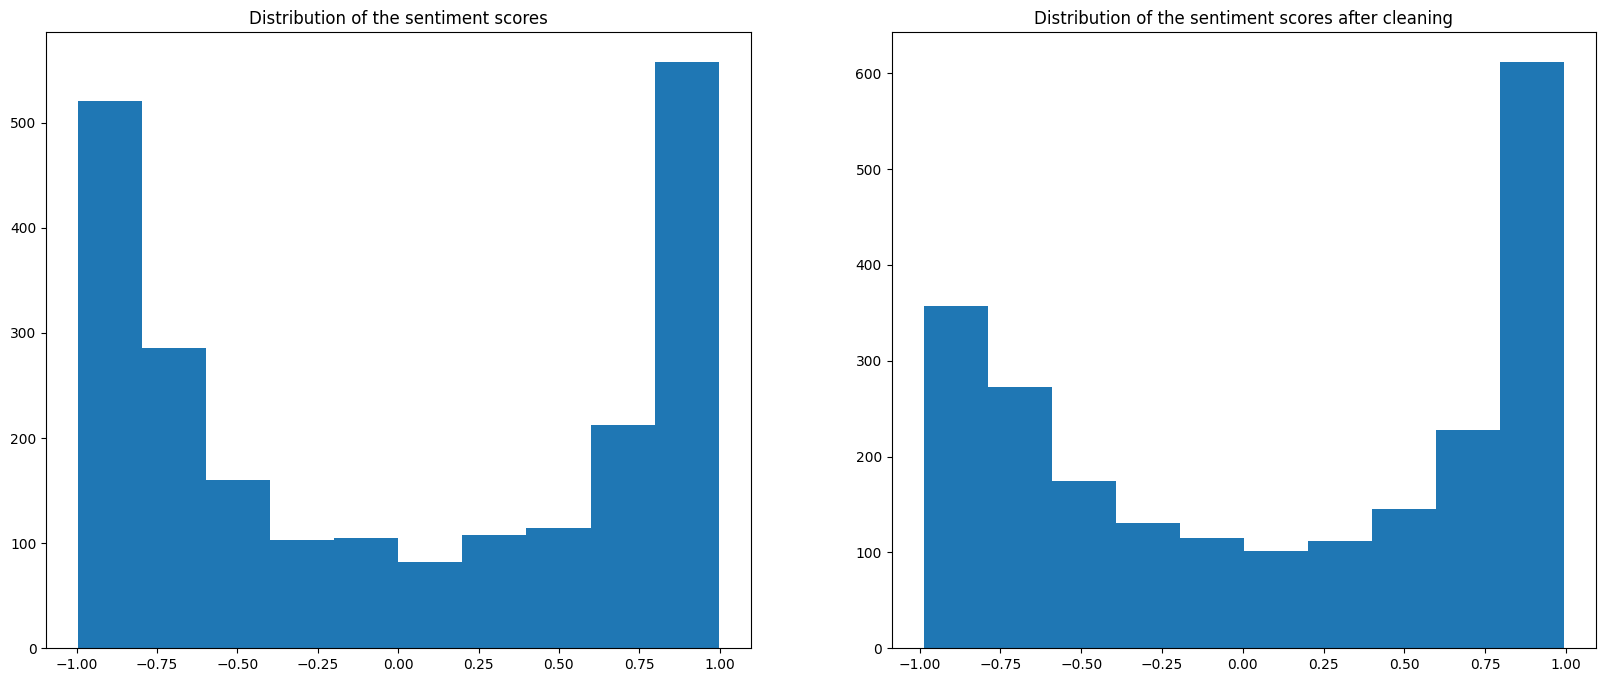

In [8]:

# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first plot
axs[0].hist(comments['compound'])
axs[0].set_title("Distribution of the sentiment scores")

# Plot the second plot
axs[1].hist(comments['compound_cleaned'])
axs[1].set_title("Distribution of the sentiment scores after cleaning")

# Show the combined plot
plt.show()

As we can see, most ratings are either positive or negative!

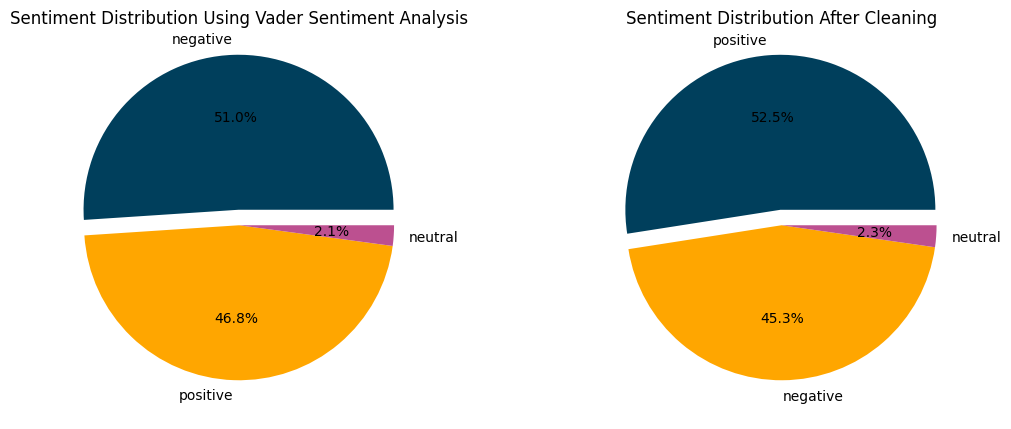

In [9]:
sentiment_proportions = comments["sentiment"].value_counts() / len(comments)
sentiment_proportions_cleaned = comments["sentiment_cleaned"].value_counts() / len(comments)

# Generate a pie chart to visualize the distribution of sentiment_proportions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first pie chart
axs[0].pie(
    sentiment_proportions,
    labels=sentiment_proportions.index,
    colors=['#003f5c', '#ffa600', '#bc5090'],
    explode=[0.1, 0, 0],
    autopct='%1.1f%%'
)
axs[0].set_title("Sentiment Distribution Using Vader Sentiment Analysis")

# Plot the second pie chart
axs[1].pie(
    sentiment_proportions_cleaned,
    labels=sentiment_proportions_cleaned.index,
    colors=['#003f5c', '#ffa600', '#bc5090'],
    explode=[0.1, 0, 0],
    autopct='%1.1f%%'
)
axs[1].set_title("Sentiment Distribution After Cleaning")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the combined plot
plt.show()

Among a total of over 2000 reviews, approximately 51.0% exhibited a positive sentiment, around 46.8% were characterized as negative, and merely 2.1% were identified as neutral. Consequently, the prevailing trend in these reviews is one of polarization, with the majority leaning towards either a positive or negative sentiment. Though, it depends on the intervals set in the `final_sentiment(compound)` function. However, these thresfolds are common and also applied for instance in https://www.kaggle.com/code/prachi13/sentiment-analysis-vader-vs-textblob

Moreover, the sentiments do not clearly depend on the preprocessing steps. After cleaning we only have a slightly higher fraction of positive comments. In the following, we will explore 10 example where the sentiment was different.

In [10]:
# Filter the dataframe for rows where sentiment and sentiment_cleaned are different
different_sentiments = comments[comments["sentiment"] != comments["sentiment_cleaned"]]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# Access the "cleaned_Comment" and "Comment" columns for the filtered rows
difference = different_sentiments[["sentiment","Comment","sentiment_cleaned", "cleaned_Comment"]]
difference.head(10)


,sentiment,Comment,sentiment_cleaned,cleaned_Comment
9,negative,"I wanted to check in online a night before our flight, but my nationality was not listed in their websites and when we wanted to check in in person they asked for a fee, and that still was not a problem! They asked for a credit card to check for late check-in fee, we asked them to pay by our debit card or by cash, but they did not accept it. So we missed our flight, and they made us pay a No show fee on the application so that they give us another flight in the evening. The flight we got was about 30 Euro and the no show fee we paid was 100 Euro. When I told them in Germany we can pay by debit card or cash, they said we are an Irish airline it has nothing to do with Germany! Then why do you have your business here? The other thing is when I mentioned my nationality was not listed on your website they did not accept that and they inserted my nationality manually!",positive,want check online night flight nationality list website want check person ask fee problem ask credit card check late checkin fee ask pay debit card cash accept miss flight pay fee application flight evening flight get euro fee pay euro tell germany pay debit card cash say irish airline germany business thing mention nationality list website accept insert nationality manually
17,positive,"Play the game and you'll be fine. Got a return flight from Leeds Bradford to Faro for £101. I booked 3 months ahead, didn't reserve a seat, and took only a small bag. Had my boarding pass both on my app, and in paper format (just in case). Took my own food and drink on the plane, didn't buy any of theirs, and didn't buy any of their duty free etc. It really does pay to do your research. At Leeds Bradford someone had lost their boarding pass (I think that cost them £60), while at Faro someone's cabin bag was too big. That had to go in the hold, and I expect that cost him. He said it was OK at Leeds, but maybe he got away with it there. My old bag would have been too big, but I checked Ryanair's website, and bought a new and conforming bag for £9.99. I'm 6 foot tall, and the leg room is tight, but just about OK for a 3 hour flight. The seats were uncomfortable though and needed more cushioning. The outward flight took off and arrived on time. The cabin crew were friendly and efficient. No hard sales pitch for food, drink, duty free. The announcements could have been clearer, but that was down to the Portuguese captain. The return flight was about an hour late taking off, due to delays experienced earlier in the day. This happens. Allow for it. They made up 20 minutes and the plane landed at Leeds Bradford 40 minutes behind schedule. Absolutely no complaints whatsoever and fantastic value for money. I'd reckon that the negative views on here are hugely in the minority. In some cases things have gone wrong, but in others part of the blame must be with the posters who haven't researched and prepared well.",negative,play game ll fine get return flight leed bradford faro book month ahead not reserve seat take small bag boarding pass app paper format case take food drink plane not buy theirs not buy duty free etc pay research leed bradford lose boarding pass think cost faro someones cabin bag big hold expect cost say ok leed maybe get away old bag big check ryanair website buy new conform bag m foot tall leg room tight ok hour flight seat uncomfortable need cushion outward flight take arrive time cabin crew friendly efficient hard sale pitch food drink duty free announcement clear portuguese captain return flight hour late take delay experience early day happen allow minute plane land leeds bradford minute schedule absolutely complaint whatsoever fantastic value money d reckon negative view hugely minority case thing go wrong blame poster not research prepare
18,negative,"Most importantly Ryanair took me from A to B, safe and in a new plane. However, often flying with Ryanair is a tiring thing. The boarding process can 

As we can see that there is some ironical touch in the ratings, which kinda screws the sentiments. In the following we will observe the polarity scores against the actual given ratings.

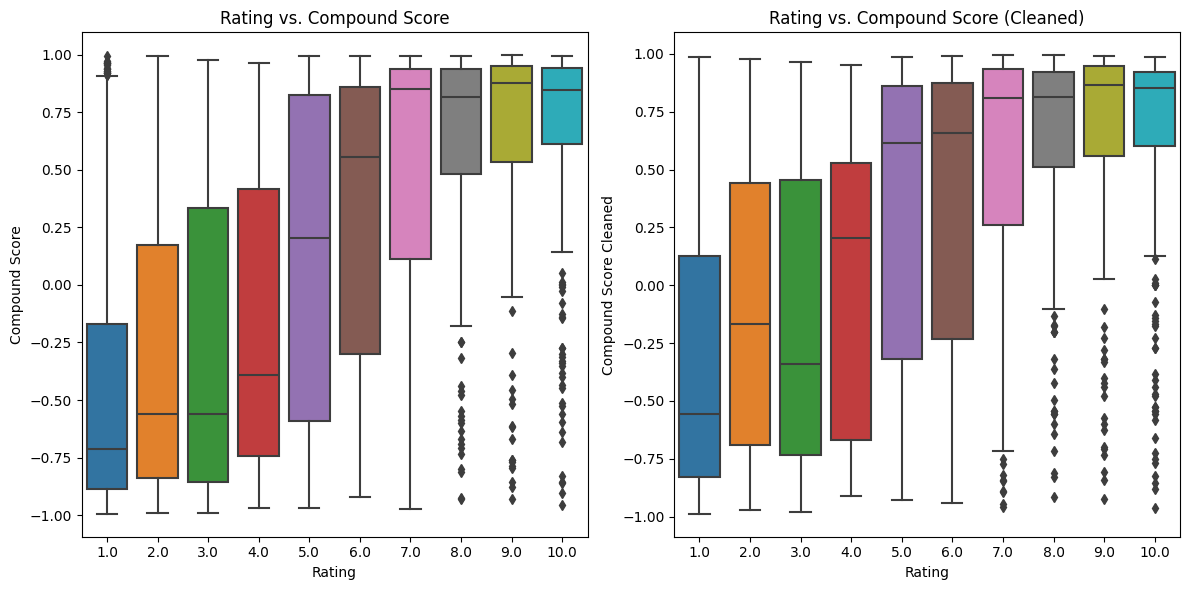

Correlation between Overall Rating and compound_cleaned: 0.5823928304246064
Correlation between Overall Rating and compound: 0.6192897825876189


In [11]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
merged = pd.concat([comments, data["Overall Rating"]], axis=1)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Rating vs. Compound Score
sns.boxplot(data=merged, x="Overall Rating", y="compound", ax=axs[0])
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Compound Score')
axs[0].set_title('Rating vs. Compound Score')

# Plot 2: Rating vs. Compound Score (Cleaned)
sns.boxplot(data=merged, x="Overall Rating", y="compound_cleaned", ax=axs[1])
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Compound Score Cleaned')
axs[1].set_title('Rating vs. Compound Score (Cleaned)')

# Show the plots
plt.tight_layout()
plt.show()

correlation = merged['Overall Rating'].corr(merged['compound_cleaned'], method='spearman')
print("Correlation between Overall Rating and compound_cleaned:", correlation)

correlation = merged['Overall Rating'].corr(merged['compound'], method='spearman')
print("Correlation between Overall Rating and compound:", correlation)

**Text Analysis and Visualisation**

In [12]:
def get_wordcloud_and_hist_of_words(column):

    # Combine all reviews into a single string
    joined_reviews = ''.join(column)
    tokenized_words = word_tokenize(joined_reviews)

    # Create a Counter to count word frequencies
    word_freq = Counter(tokenized_words)

    # Get the most common words and their frequencies
    common_words = word_freq.most_common(30)

    # Get the labels and values for the histogram
    labels, values = zip(*common_words)

    # Create the histogram
    plt.bar(labels, values)

    # Set the x-axis labels to be vertical
    plt.xticks(rotation=90)

    # Set labels
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequency')
    plt.show()

    # Generate the word cloud
    wordcloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


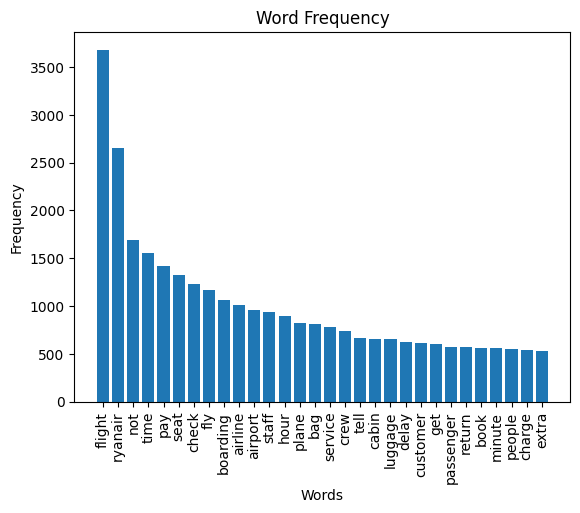

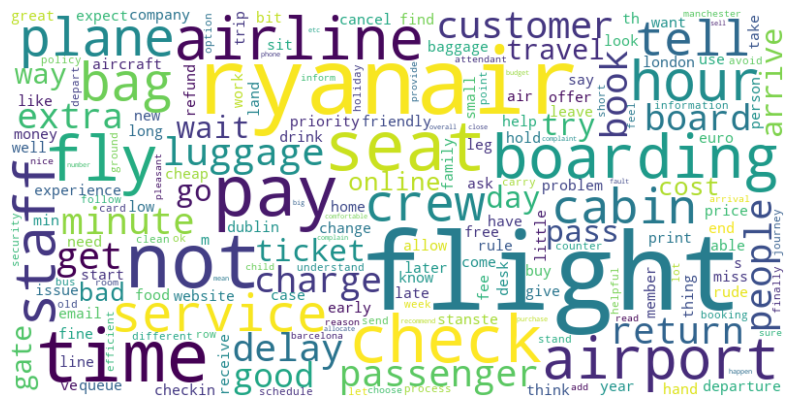

In [13]:
get_wordcloud_and_hist_of_words(comments["cleaned_Comment"])